In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

import matplotlib.pyplot as plt

In [66]:
def synthesize_data(n_batch, n_features, sparsity, device=None):
    feat = torch.rand((n_batch, n_features))
    batch = torch.where(
        torch.rand((n_batch, n_features)) <= sparsity,
        torch.zeros(()),
        feat,
    )
    if device is not None:
        batch = batch.to(device)
    return batch

In [17]:
b = synthesize_data(100, 5, 0.3, "mps")
print(f'Generated data {b.shape=}')
print(b[:10])

Generated data b.shape=torch.Size([100, 5])
tensor([[0.0000, 0.3594, 0.0768, 0.0000, 0.0000],
        [0.5591, 0.0000, 0.0000, 0.0000, 0.0289],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1333, 0.0000, 0.0000, 0.4642, 0.0000],
        [0.0000, 0.9046, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3226],
        [0.4077, 0.0000, 0.0000, 0.0000, 0.7225],
        [0.0000, 0.2726, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0560, 0.0000, 0.8027],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='mps:0')


In [5]:
class LinearModel(nn.Module):
    def __init__(self, n_features=5, n_hidden=2, device="mps"):
        super().__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.device = device
        
        self.W = nn.Parameter(torch.empty(self.n_hidden, self.n_features, device=self.device))
        nn.init.xavier_normal_(self.W)
        self.b = nn.Parameter(torch.zeros(self.n_features, device=self.device))

    def forward(self, features):
        # features: batch x n_features
        # self.W: n_hidden x n_features
        h = features @ self.W.T     # batch x n_hidden
        x_reconstructed = h @ self.W + self.b[None,...]
        return x_reconstructed   # batch x n_features
 
    def loss(self, x, x_reconstructed):
        return ((x - x_reconstructed)**2).sum()


class ReLUModel(LinearModel):
    def forward(self, features):
        out = super().forward(features)
        return f.relu(out)

In [26]:
model = ReLUModel()
output = model(b[0:1])
print(output)

tensor([[0.0000, 0.0045, 0.0024, 0.0133, 0.0068]], device='mps:0',
       grad_fn=<ReluBackward0>)


In [29]:
output = model(b)
print(output.shape)

torch.Size([100, 5])


In [73]:
torch.arange(n_features, device="mps")[None,...]

torch.Size([1, 20])

In [82]:
train_steps = 50_000
batch_size = 1024
n_features = 20
n_hidden = 5
sparsity = 0.99
feature_importance = 0.7 ** torch.arange(n_features, device="mps")[None,...]
lr = 5e-4

model = ReLUModel(n_features=n_features, n_hidden=n_hidden)
optimizer = optim.AdamW(model.parameters(), lr=lr)
for step_idx in range(train_steps):
    optimizer.zero_grad()
    input_batch = synthesize_data(batch_size, n_features, sparsity, "mps")
    output = model(input_batch)
    loss = (((input_batch - output) ** 2) * feature_importance).sum(dim=1).mean()
    loss.backward()
    optimizer.step()
    if step_idx % 2000 == 0:
        print(step_idx, loss.detach().item())

0 0.009171229787170887
2000 0.0024805613793432713
4000 0.0014970822958275676
6000 0.001552590518258512
8000 0.0022003711201250553
10000 0.002331472933292389
12000 0.0016964117530733347
14000 0.0017785521922633052
16000 0.0018168676178902388
18000 0.001715314225293696
20000 0.0019117274787276983
22000 0.0015884158201515675
24000 0.00173751765396446
26000 0.002007296308875084
28000 0.0020152186043560505
30000 0.0012634918093681335
32000 0.001782956882379949
34000 0.0018191125709563494
36000 0.0014095264486968517
38000 0.0022125677205622196
40000 0.0016947684343904257
42000 0.0013979184441268444
44000 0.002559907268732786
46000 0.001857928466051817
48000 0.0017361317295581102


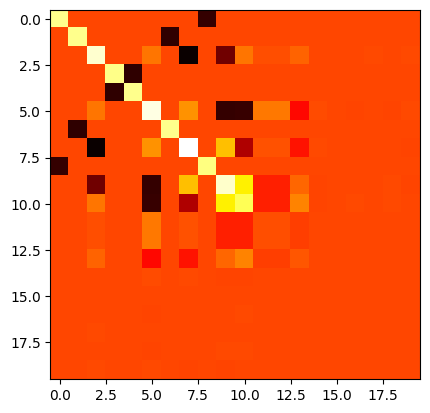

In [81]:
with torch.no_grad():
    xyz = (model.W.T @ model.W).detach().cpu().numpy()
    plt.imshow(xyz, cmap="hot", interpolation="nearest")

In [57]:
with torch.no_grad():
    input_batch = synthesize_data(2, n_features, sparsity, "mps")
    output = model(input_batch)
    print(input_batch)
    print(output)

tensor([[0.7817, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7199, 0.3014, 0.0000, 0.0000]], device='mps:0')
tensor([[0.8162, 0.1524, 0.0000, 0.0167, 0.0168],
        [0.0000, 0.1521, 0.3268, 0.0182, 0.0156]], device='mps:0')
